In [220]:
!pip install implicit -qqq

## Practical example of Matrix Factorisation

- Согодня приступим к практической части по созданию рекомендации используя методы матричного разложения
- Будем использовать метод разложения `iALS` 
- Данные будут из MTS; приложение для чтения электронных книг, прессы и прослушивания аудиокниг, доступно для абонентов всех мобильных операторов, продукт экосистемы МТС


Затронем 4 пункта:
- (1) Implicit feedback матричные подход 
- (2) Explicit feedback матричные подход
- (3) Online (Обновление текущей score матрицы)
- (4) Предсказание для одного пользователя

### <b><span style='color:#686dec'>Импортируем модули </span></b>

In [221]:
import numpy as np
import pandas as pd
import os
import implicit
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
import scipy
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
from tqdm import tqdm

### <b><span style='color:#686dec'>Общие параметр</span></b>

Можем сразу определится с общими параметры которые будут использоватся в ноуте

In [222]:
USER_COL = 'user_id'  # колонка пользователей 
ITEM_COL = 'item_id'  # колонка с предметами
EXP_RATING_COL = 'rating' # рейтинг предмета; книги
IMP_RATING_COL = 'progress' # 
TIMESTAMP = 'start_date'

### <b><span style='color:#686dec'>Чтение данных</span></b>

Для формирования рекоммендации, будем использовать данные действий пользователей 

In [223]:
df = pd.read_csv('/kaggle/input/mts-library/interactions.csv')
df.head()

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01
2,66991,198453,89,NaN,2018-01-01
3,46791,83486,23,5.0,2018-01-01
4,79313,188770,88,5.0,2018-01-01


In [224]:
df.dtypes 

user_id         int64
item_id         int64
progress        int64
rating        float64
start_date     object
dtype: object

В наших данных, у нас есть информацию о времени совершенного действия `start_date`

In [225]:
# конверируем данные для [start_date]
df['start_date'] = df['start_date'].astype('datetime64[ns]')

# убираем дубликаты для комбинации [user_id] [item_id] ie. одна запись в день / пользователь
df = df.sort_values('start_date').drop_duplicates(subset=['user_id', 'item_id'], keep='last')

### <b><span style='color:#686dec'>Exploratory Data Analysis</span></b>

Как всегда, давай иследуем наши данные 

#### user_id & item_id

Количество уникальных пользователей `user_id` и книг `item_id` в датасете

In [226]:
df[USER_COL].value_counts()

user_id
41297     2091
150282    1352
155199     850
143558     832
86301      822
          ... 
47123        1
217          1
152642       1
64702        1
23916        1
Name: count, Length: 151600, dtype: int64

In [227]:
df[ITEM_COL].value_counts()

item_id
99357     6575
316995    2706
109201    2585
241026    2300
28889     2287
          ... 
205629       4
171910       3
132600       3
93290        3
285283       2
Name: count, Length: 59599, dtype: int64

#### User Feedback

У нас две колонки с feedback пользователях;
- `rating` (пользователь оставил отзыв) [explicit]
- `progress` (доля прочитанной книги) [implicit]

**Explicit**
- мало, иногда недоступен
- явно отражает предпочтения пользователя

**Implicit**
- много
- разнородный
- часто не содержит негативного опыта/его надо извлекать на основе правил
- косвенно показывает предпочтения пользователей

Пользователи взаимодействуют с книгами, которые им, скорее всего, понравятся, и предпочитают ставить оценки понравившимся, поэтому в реальных данных часто наблюдается смещение в сторону положительных оценок.

In [228]:
df[EXP_RATING_COL].value_counts(dropna=False)

rating
NaN    1247661
5.0     214703
4.0      40382
3.0      18273
1.0       6115
2.0       5864
Name: count, dtype: int64

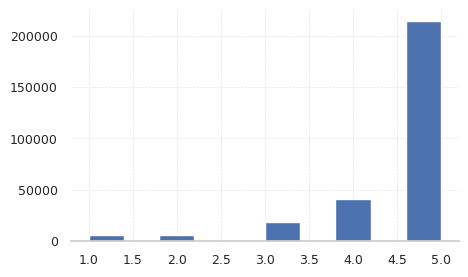

In [229]:
ax = df['rating'].hist(bins=10, figsize=(5,3));
ax.grid(color='gray', linestyle='--', linewidth=0.5,alpha=0.2) 
ax.tick_params(axis='both', labelsize=9)
sns.despine(top=True,left=True,right=True)
plt.show()

На счет `progress`, мы видим что нет пропусков и большинство пользователей либо не начали читать либо прочитали книгу 

In [230]:
df['progress'].value_counts(dropna=False)

progress
100    228230
0      200915
99      56710
1       48356
2       33917
        ...  
74       8427
79       8426
76       8407
58       8316
63       8267
Name: count, Length: 101, dtype: int64

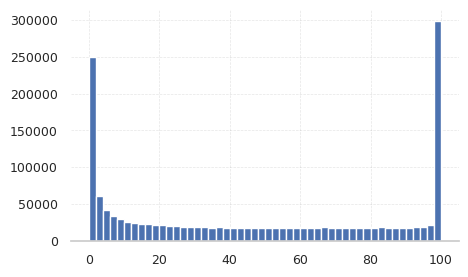

In [231]:
ax = df['progress'].hist(bins=50, figsize=(5,3));
ax.grid(color='gray', linestyle='--', linewidth=0.5,alpha=0.2) 
ax.tick_params(axis='both', labelsize=9)
sns.despine(top=True,left=True,right=True)
plt.show()

#### Количество прочтений для всех пользователей

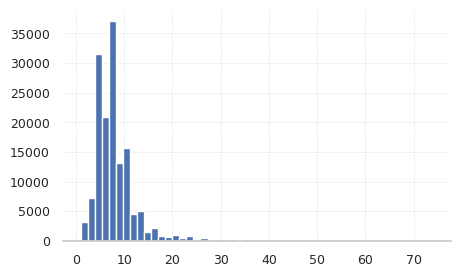

In [232]:
# количество книг per пользователь
user_groups = df.groupby('user_id')['item_id'].count()
ax = user_groups[user_groups < user_groups.quantile(0.99)].hist(bins=50,figsize=(5,3));
ax.grid(color='gray', linestyle='--', linewidth=0.5,alpha=0.2) 
ax.tick_params(axis='both', labelsize=9)
sns.despine(top=True,left=True,right=True)
plt.show()

#### Количетсво прочтений каждой книги

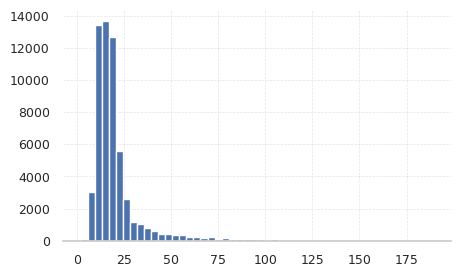

In [233]:
item_groups = df.groupby('item_id')['user_id'].count()
ax = item_groups[item_groups < item_groups.quantile(0.99)].hist(bins=50,figsize=(5,3));
ax.grid(color='gray', linestyle='--', linewidth=0.5,alpha=0.2) 
ax.tick_params(axis='both', labelsize=9)
sns.despine(top=True,left=True,right=True)
plt.show()

### <b><span style='color:#686dec'>Подготавливаем выборки</span></b>

- Мы увидили что для **implicit** feedback `progress` у нас нет проблем с пропусками
- А для колонки **explicit** feedback `rating` у нас намного меньше данных так как у нас много пропусков, 
- Разобъем выборку на две части `df_implicit` и `df_explicit`

In [234]:
df_implicit = df.copy()
df_explicit = df.dropna()

print('implicit',df_implicit.shape)
print('explicit',df_explicit.shape)

implicit (1532998, 5)
explicit (285337, 5)


### <b><span style='color:#686dec'>Фильтрация данных</span></b>

Фильтруем пользователей, у которых меньше 10 прочитанных книг и книги, которые прочли менее 20 пользователей.

In [235]:
def filter_data(df, user_count=10, item_count=10):
    
    # book filter 
    item_counts = df.groupby(ITEM_COL)[USER_COL].count()
    pop_items = item_counts[item_counts > user_count]
    df_implicit = df[df[ITEM_COL].isin(pop_items.index)]

    # user filter 
    user_counts = df.groupby(USER_COL)[ITEM_COL].count()
    pop_users = user_counts[user_counts > item_count]
    df = df[df[USER_COL].isin(pop_users.index)].copy()
    return df

In [236]:
df_implicit = filter_data(df_implicit, 
                          user_count=10, 
                          item_count=20)
df_implicit.shape[0]

459065

### <b><span style='color:#686dec'>Train-test-split</span></b>

Раздел на `train` / `test` имеет свои нюансы 
- `train` будет использоватся для обучения (разложение матрицы)
- `test` содержит не только `train` но и все кроме последнего предсказания всех пользователей
- `test` будет использоватся в разделе `online prediction`, в нем содержатся только те пользователи/предметы которые попали и в `train`

In [237]:
def train_test_split(
    clickstream_df,
    test_quantile=0.9):
    
    '''
    
    Split clickstream by date
    
    '''
    
    clickstream_df = clickstream_df.sort_values([USER_COL, TIMESTAMP])
    
    # test set timestamp
    test_timepoint = clickstream_df[TIMESTAMP].quantile(
                                    q=test_quantile, 
                                    interpolation='nearest')
    

    # train/test split by timestamp
    test = clickstream_df.query(f'{TIMESTAMP} >= @test_timepoint')    
    train = clickstream_df.drop(test.index)

    # test must contain users & books found in training set
    test = test[test[USER_COL].isin(train[USER_COL])]
    test = test[test[ITEM_COL].isin(train[ITEM_COL])]
    
    # sort & group by for each user
    # test will be last user item read status; train will be all other
    test_full_history = test.sort_values([USER_COL, TIMESTAMP]).groupby(USER_COL)
    last_item = test_full_history.tail(1)
    test_history = test_full_history.head(-1)

    test = pd.concat([train, test_history])

    test.reset_index(drop=True, inplace=True)
    train.reset_index(drop=True, inplace=True)
    
    return train, test, last_item

In [238]:
train, test, last_item = train_test_split(df_implicit)

print(train.shape)
print(test.shape)
print(last_item.shape)

(412826, 5)
(449660, 5)
(4559, 5)


In [239]:
print('train start',train['start_date'].min())
print('train end',train['start_date'].max())
print('test start',test['start_date'].min())
print('test end',test['start_date'].max())
print('last item start',last_item['start_date'].min())
print('last item end',last_item['start_date'].max())

train start 2018-01-01 00:00:00
train end 2019-10-22 00:00:00
test start 2018-01-01 00:00:00
test end 2019-12-31 00:00:00
last item start 2019-10-23 00:00:00
last item end 2019-12-31 00:00:00


### <b><span style='color:#686dec'>Фильтруем `last_time`</span></b>

Выбираем из `last_time` только тех пользователей которые прочитали больше 10% книги

In [240]:
last_item = last_item[last_item[IMP_RATING_COL] >= 10]
last_item.shape

(3675, 5)

### <b><span style='color:#686dec'>Вспомогательные Функции</span></b>

- **`get_sparse_matrix`** : Создает матрицу взаимосвязи `rating_col` пользователей и предметов 
- **`get_scores`** : Скалярное произвидение `user_id` матрицу и `item_id` матрицу : score matrix
- **`predict`** : **Top k** рекоммендации по итогу score matrix
- **`hr`** : Метрика hitrate

In [241]:
def get_sparse_matrix(df, rating_col):
    
    """

    Create sparse matrix (like via pivot_table)
    but directly into sparse_matrix format
    
    rating_col : value column (implicit/explicit)

    """
    
    rating = list(df[rating_col]) # rating
    rows = df[USER_COL].astype('category').cat.codes # userid
    cols = df[ITEM_COL].astype('category').cat.codes # bookid
    df_sparse = sparse.csr_matrix((rating, (rows, cols)))
    
    return df_sparse, rows, cols


def get_scores(user_vecs, 
               item_vecs, 
               rating_matrix):
    
    """
    
    Get the score matrix from the user & item matrices
    don't include the books that have already been read
    
    R = U_{d} V^{T}_{d}
    
    """
    
    scores = user_vecs.dot(item_vecs.T)
    scores = np.multiply(scores,
        np.invert(rating_matrix.astype(bool))
        )
    return scores

def predict(scores, rows, cols, k=10):
    
    """
    
    Using the score matrix from [get_scores] return the 
    sorted recommendations based on the highest top k scores
    for each user
    
    """
    
    id2user = dict(zip(rows, train.user_id))
    id2item = dict(zip(cols, train.item_id))

    ind_part = np.argpartition(scores, -k + 1)[:, -k:].copy()
    scores_not_sorted = np.take_along_axis(scores, ind_part, axis=1)
    ind_sorted = np.argsort(scores_not_sorted, axis=1)
    indices = np.take_along_axis(ind_part, ind_sorted, axis=1)

    preds = pd.DataFrame({
        USER_COL: range(scores.shape[0]),
        'preds': np.flip(indices, axis=1).tolist(),
        })
    
    preds[USER_COL] = preds[USER_COL].map(id2user)
    preds['preds'] = preds['preds'].map(lambda inds: [id2item[i] for i in inds])
    return preds

# metric hitrate
def hr(df: pd.DataFrame, 
       pred_col='preds', 
       true_col='item_id') -> float:
    
    hr_values = []
    for _, row in df.iterrows():
      hr_values.append(int(row[true_col] in row[pred_col]))
    return round(np.mean(hr_values), 4)

### <b><span style='color:#686dec'>(a) Implicit</span></b>

Используя долю прочитанных книг для `rating`

#### **ALS Decomposition**

- Разложим матрицу пользовательского прогресса различных книг `train_sparse`
- Возмем только 50 факторов как гиперпараметр

In [243]:
# train_sparse : user, book progress sparse matrix
# IMP_RATING_COL : 'progress'
train_sparse, train_rows_imp, train_cols_imp = get_sparse_matrix(train, 
                                                                 IMP_RATING_COL)

Напрямую хранить все данные нам не имеет смысла, посмотрим каая доля у нас вообще есть 

In [245]:
# matrix decomposition of user item interaction matrix
algo = implicit.als.AlternatingLeastSquares(factors=50, 
                                            regularization=0.1, 
                                            iterations=50, 
                                            use_gpu=False)
algo.fit((train_sparse).astype('double'))

  0%|          | 0/50 [00:00<?, ?it/s]

In [246]:
user_vecs = algo.user_factors; print(user_vecs.shape) # user matrix containing 50 features
item_vecs = algo.item_factors; print(item_vecs.shape) # item matrix containing 50 featyres 

(7561, 50)
(51358, 50)


In [247]:
# score matrix for implicit approach
scores_imp = get_scores(user_vecs, 
                        item_vecs, 
                        train_sparse.todense())

In [248]:
# create recommendations 
pred_imp = predict(scores_imp, 
                   train_rows_imp, 
                   train_cols_imp)

# limit recommendations to only users 
pred_imp = pred_imp.merge(last_item, how='right', on='user_id')

In [271]:
pred_imp.head()

,user_id,preds,item_id,progress,rating,start_date
0,21,"[173707, 126214, 161550, 152551, 134598, 68549...",227443,100,5.0,2019-12-19
1,43,"[84620, 39160, 306076, 70926, 181053, 18541, 7...",161017,62,NaN,2019-12-26
2,77,"[230045, 295007, 155266, 292066, 270415, 16985...",235407,69,NaN,2019-12-13
3,83,"[152716, 186680, 85287, 249564, 192249, 153677...",312297,51,NaN,2019-11-11
4,219,"[45897, 81342, 39160, 18541, 108080, 150442, 8...",3192,99,NaN,2019-12-10


In [288]:
hr(pred_imp)

0.0103

### <b><span style='color:#686dec'>(b) Explicit</span></b>

Используя рейтинги пользователей построим матрицу взаимосвязи пользователя и товара 

#### **ALS Decomposition**

- Разложим матрицу пользовательского рейтингов книг `train_sparse`
- Возмем только 50 факторов как гиперпараметр

In [251]:
df_explicit = filter_data(df_explicit, 
                          user_count=10, 
                          item_count=10)
df_explicit.shape[0]

101373

Разбиваем данные на три части; как и раньше. Но для explicit подхода мы оставим только рейтинги книг 4 и выше

In [252]:
train, test, last_item = train_test_split(df_explicit)
last_item = last_item[last_item[EXP_RATING_COL] >= 4]

In [253]:
# create training sparse matrix
train_sparse, train_rows_exp, train_cols_exp = get_sparse_matrix(train, 
                                                                 EXP_RATING_COL)

In [255]:
algo = implicit.als.AlternatingLeastSquares(factors=50, 
                                            regularization=0.1, 
                                            iterations=50, 
                                            use_gpu=False)
algo.fit((train_sparse).astype('double'))

  0%|          | 0/50 [00:00<?, ?it/s]

In [256]:
user_vecs = algo.user_factors # user matrix  (50 features)
item_vecs = algo.item_factors  # item matrix (50 features)

# проверим по размерам, что мы действиельно не перепутали users и items
print(train_sparse.shape)
print(user_vecs.shape, item_vecs.shape)

(2514, 17943)
(2514, 50) (17943, 50)


In [281]:
# Using score matrix get the score matrix
scores_exp = get_scores(user_vecs, 
                        item_vecs, 
                        train_sparse.todense())

scores_exp.shape # (2514 users, 17943 items)

(2514, 17943)

In [284]:
# Make a recommendation prediction for each user using score matrix
pred_exp = predict(scores_exp, 
                   train_rows_exp, 
                   train_cols_exp)

print(pred_exp.head())
print(pred_exp.shape)

   user_id                                              preds
0       21  [261138, 187501, 39765, 23553, 88397, 45920, 2...
1       83  [251645, 152716, 220122, 192249, 228394, 18668...
2      156  [198447, 271811, 78934, 216356, 22675, 144406,...
3      219  [77729, 77581, 75360, 43255, 113015, 222246, 2...
4      359  [23553, 34917, 140991, 221178, 234400, 83902, ...
(2514, 2)


Сделаем рекомендацию пользователям из `last_item` которые оценивали книги (4+)

In [287]:
# give recommendation to users who rated books 4+ only
pred_exp = pred_exp.merge(last_item, how='right', on='user_id')
pred_exp.shape

(771, 6)

In [258]:
hr(pred_exp)

0.0285

- По идей если мы хотим сравнить метрики между двумя подходами, нам лучше сравнивать похожие по размерности выборки (один и тот же набор пользователей)
- explicit feedback дает нам немного лучше hitrate

### <b><span style='color:#686dec'>(c) Online Prediction </span></b>

- Пользователи сделали дополнительные действия и мы хотим дать им новые рекоммендации
- Мы подготовили в разделе **Train-test-split** выборку `test` (в ней у нас содержится `train` и дополнительные действий текущих пользователей что и в `train`)
- Но хотим без переобучения модели (сново разложим матрицу 'рейтингов') 
- Мы можем делать $ \hat{R} = R V_{d} V^{T}_{d}$ те использовать текущию матрицу 



  

Создадим sparse матрицу рейтингов книг пользователей для всей `test`

In [289]:
# create sparse matrix of user, book [rating] sparse matrix 
test_sparse, test_rows_exp, test_cols_exp = get_sparse_matrix(test, 
                                                              EXP_RATING_COL)

In [260]:
def get_scores_new_actions(item_vecs, 
                           updated_rating_matrix):
   
    """
    
    [item_vecs] : 
    [updated_rating_matrix] : new rating matrix of user/item combination
    
    """

    scores = updated_rating_matrix.dot(item_vecs) @ item_vecs.T
    scores = np.multiply(scores,
        np.invert(updated_rating_matrix.astype(bool))
        )
    return scores

Будем переиспользовать матрицу `item_vecs` (разложенную матриу предметов)

In [290]:
item_vecs.shape

(17943, 50)

In [291]:
# update existing scores using new use rating sparse matrix & existing item matrix
scores_exp_updated = get_scores_new_actions(item_vecs, 
                                            test_sparse.todense())

# update recommendations
pred_exp_updated = predict(scores_exp_updated, 
                           test_rows_exp, 
                           test_cols_exp)

pred_exp_updated = pred_exp_updated.merge(last_item, 
                                          how='right', 
                                          on='user_id')
pred_exp_updated.head()

,user_id,preds,item_id,progress,rating,start_date
0,21,"[199064, 11614, 148773, 285903, 299349, 196161...",227443,100,5.0,2019-12-19
1,156,"[78934, 271811, 198447, 216356, 22675, 265425,...",101867,100,5.0,2019-12-26
2,219,"[251645, 77581, 77729, 43255, 75360, 113015, 2...",109265,99,5.0,2019-11-03
3,359,"[23553, 34917, 140991, 221178, 234400, 83902, ...",256193,100,5.0,2019-11-26
4,474,"[210268, 65830, 113403, 6943, 90671, 179716, 2...",235407,100,5.0,2019-12-25


Качество немного улучшилось; ка счет того что мы добавили новые действия

In [292]:
hr(pred_exp_updated)

0.048

Проверим качество, используя только действия из трейна.

In [293]:
scores_exp = get_scores_new_actions(item_vecs, 
                                    train_sparse.todense())
pred_exp = predict(scores_exp, train_rows_exp, train_cols_exp)
pred_exp = pred_exp.merge(last_item, how='right', on='user_id')
hr(pred_exp)

0.0272

### <b><span style='color:#686dec'>(d) Предсказание для одного пользователя</span></b>

Теперь посмотрим как мы можем сделать рекоммендации для одного пользователя

In [294]:
# book information data
items = pd.read_csv('/kaggle/input/mts-library/items.csv')
items.head()

,id,title,genres,authors,year
0,128115,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,210979,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,95632,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869
3,247906,Странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
4,294280,Господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873


In [313]:
# mappers to actual user_id and item_id from the dataset
# we used ordered user and item identifiers from 0

id2user = dict(zip(test_rows_exp,test.user_id))
id2item = dict(zip(test_cols_exp,test.item_id))
print(id2item[0],id2user[0])

13 21


Метод `recommend` из библиотеки `implicit` позволяет нам делать рекомендацию для одного пользователя

In [296]:
# method realised in library implicit
recommendations = algo.recommend(0, test_sparse[0])
recommendations # (index array,scores array)

(array([14547, 10450,  2246,  1322,  4866,  2586,   124,  1238, 11283,
         7814], dtype=int32),
 array([0.12248802, 0.11428122, 0.11298379, 0.11208673, 0.11028358,
        0.1084349 , 0.1075625 , 0.10495262, 0.10148995, 0.10100657],
       dtype=float32))

Посмотрим на рекомендацидля этого пользователя

In [304]:
# recommendations for user id=0
pd.DataFrame([id2item[i] for i in recommendations[0]]).merge(items, left_on=0, right_on='id')

,0,id,title,genres,authors,year
0,261138,261138,Летос,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2014
1,187501,187501,Разрушитель божественных замыслов,"Героическое фэнтези,Попаданцы,Боевое фэнтези",Владимир Сухинин,2017
2,39765,39765,Первые сполохи войны,"Героическое фэнтези,Попаданцы,Боевое фэнтези",Владимир Сухинин,2018
3,23553,23553,Вся правда о нас,"Детективное фэнтези,Городское фэнтези,Книги пр...",Макс Фрай,2015
4,88397,88397,Пешка в большой игре,"Героическое фэнтези,Попаданцы,Боевое фэнтези",Владимир Сухинин,2017
5,45920,45920,Вторая жизнь майора,"Героическое фэнтези,Попаданцы,Боевое фэнтези",Владимир Сухинин,2017
6,2028,2028,Скорпион Его Величества,"Героическое фэнтези,Попаданцы,Боевое фэнтези",Владимир Сухинин,2018
7,22066,22066,Заложник долга и чести,"Героическое фэнтези,Попаданцы,Боевое фэнтези",Владимир Сухинин,2018
8,202547,202547,Чужая сила,"Городское фэнтези,Книги про волшебников",Андрей Васильев,2017
9,140991,140991,Лабиринт Мёнина (сборник),"Детективное фэнтези,Героическое фэнтези,Городс...",Макс Фрай,2000


Посмотрим на историю взаимодействий пользователя

In [306]:
# user read history
user_history = test[test[USER_COL] == 21][[ITEM_COL]] # user idx=0, id=21
user_history.merge(items, left_on='item_id', right_on='id')

,item_id,id,title,genres,authors,year
0,193711,193711,История Бернарды и Тайры на Архане,"Любовно-фантастические романы,Научная фантасти...",Вероника Мелан,2015
1,32399,32399,Спектр,"Социальная фантастика,Космическая фантастика,Н...",Сергей Лукьяненко,2001-02
2,155015,155015,Выиграть жизнь. Сказки из сундука,"Этнография,Книги о путешествиях",Виталий Сундаков,2018
3,121640,121640,Золотые костры,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2012
4,136668,136668,Синее пламя,"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2015
5,11951,11951,Талорис,"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2019
6,204089,204089,Змейка,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2005
7,128170,128170,Инстинкт зла. Тень,"Эротическое фэнтези,Городское фэнтези,Любовное...",Марина Суржевская,2017
8,31873,31873,Инстинкт Зла. Вершитель,"Эротическое фэнтези,Городское фэнтези,Любовное...",Марина Суржевская,2016
9,131575,131575,Инстинкт Зла. Возрожденная,"Эротическое фэнтези,Городское фэнтези,Любовное...",Марина Суржевская,2016
